## Web Analytics DATA 620 | Project 2 

Group members: Abdellah Ait Elmouden, Habib Khan, Priya Shaji, Vijaya Cherukuri

The work in this project represent an analysis of affiliations between authors and journals in the 2-mode [NASA Astrophysics Data Systems dataset]. The primary objective of this project is to use clustering techniques (e.g. the island method) to try to find small sub-networks of important authors that are frequently collaborating together. In doing so we can also see which journals stand out as focal points for these types of collaborations.

### Import Requiered Modules

In [1]:
import networkx as nx
import os
import ads as ads # A Python Module to Interact with NASA’s ADS available here https://ads.readthedocs.io/en/latest/#
import matplotlib.pyplot as plt
import pandas as pd
import ipycytoscape # A cool widget enabling interactive graph visualization
from networkx.algorithms import bipartite as bi

### Load the Data and Create the Dataframe

We will build a dataset using the NASA Astrophysics Data System (SAO/NASA ADS) API. In order to do that We'll use the environment variables os.environ to store API tokens.

In [41]:
os.environ["ADS_DEV_KEY"] = "wNFXZ7f0VQnfStI8zo0rDFNthx5rLJYQhDMm2NFS" # Store the key in an enviromental variable

In [42]:
ads.config.token = 'ADS_DEV_KEY'

Now we can Search for papers on ADS. Let's search for the 50 most cited on gravity.

In [43]:
papers = list(ads.SearchQuery(q= "gravity waves", sort="citation_count", max_pages=1 )) # "gravity waves as search keyword"
print(len(papers))

50


In [44]:
# Let's find the author names 
a = []
for i in papers:
    authors1 = i.author
    a.append(authors1)
author_names = a

In [45]:
# Let's find the journals
j = []
for i in papers:
    journals1 = i.pub
    j.append(journals1)
journals = j

/home/taha/anaconda3/lib/python3.7/site-packages/ads/utils.py:31: UserWarning: You are lazy loading attributes via 'pub', and so are making multiple calls to the API. This will impact your overall rate limits.
  UserWarning,


In [46]:
# Now we'll create an initial df
df = pd.DataFrame({'Author_Names' : author_names,
 'Journal':journals
  })
df.head()

,Author_Names,Journal
0,"[Spergel, D. N., Bean, R., Doré, O., Nolta, M....",The Astrophysical Journal Supplement Series
1,"[Abbott, B. P., Abbott, R., Abbott, T. D., Abe...",Physical Review Letters
2,"[Komatsu, E., Dunkley, J., Nolta, M. R., Benne...",The Astrophysical Journal Supplement Series
3,"[Spitzer, Lyman]",A Wiley-Interscience Publication
4,"[Abbott, B. P., Abbott, R., Abbott, T. D., Ace...",Physical Review Letters


In [48]:
# Let's expand the df with melt
s1 = df.apply(lambda x: pd.Series(x['Author_Names']),axis=1).stack().reset_index(level=1, drop=True)
s1.name = 'Author_Name'
df_m = df.drop('Author_Names', axis=1).join(s1)
df_m['Journal'].unique().tolist() # To check the list of Journals

['The Astrophysical Journal Supplement Series',
 'Physical Review Letters',
 'A Wiley-Interscience Publication',
 'Physics Reports',
 'The Astrophysical Journal',
 'Physical Review',
 'Physics of Fluids',
 'Astronomy and Astrophysics',
 'Applied Physics B: Lasers and Optics',
 'Science',
 'The International Series of Monographs on Physics',
 'Reviews of Modern Physics',
 'Journal of Geophysical Research',
 'Canadian Journal of Physics',
 'Annual Review of Astronomy and Astrophysics',
 'Nature',
 'Reviews of Geophysics',
 'Proceedings of the Royal Society of London Series A',
 'Living Reviews in Relativity',
 'Physical Review D',
 'Classical and Quantum Gravity',
 'Journal of Atmospheric Sciences']

### Create the Graph

In [49]:
author_nodes = pd.DataFrame(df_m.Author_Name.unique(),columns=['Author_Name'])
author_nodes['node_type'] = 'Author_Name'
journal_nodes = pd.DataFrame(df_m.Journal.unique(), columns=['Journal'])
journal_nodes['node_type'] = 'Journal'

In [50]:
# Build the graph from the node sets and edges
# set bipartite attribute to ensure weighted projection will work
a_nodes = list(author_nodes['Author_Name'])
j_nodes = list(journal_nodes['Journal'])
edge_bunch = [tuple(i) for i in df_m.values]

g = nx.Graph()
g.add_nodes_from(a_nodes,node_type='Author_Name', bipartite=0)
g.add_nodes_from(j_nodes,node_type='Journal', bipartite=1)
g.add_edges_from(edge_bunch)

![2mode](imgs/2mode.png)

In [51]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4064
Number of edges: 5357
Average degree:   2.6363


In [ ]:
#plt.figure(figsize=(14, 10))
#nx.draw(g, with_labels=True, node_size=50, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)
#plt.savefig("graph.pdf")


graph = ipycytoscape.CytoscapeWidget()
graph.graph.add_graph_from_networkx(g)

graph.set_style([{
                        'selector': 'node',
                        'css': {
                            'content': 'a_islands(authors)',
                            'text-valign': 'center',
                            'color': 'white',
                            'text-outline-width': 2,
                            'text-outline-color': 'green',
                            'background-color': 'green'
                        }
                        }])

graph

In [52]:
# Weighted Projections/Clustering
# find the largest most connected graph - 200 as cut-off 

def connected_component_subgraphs(G): # the connected_component_subgraphs attribute is not availble after Networkx 2.4
    for c in nx.connected_components(G):
        yield G.subgraph(c)

big_subg = [i for i in connected_component_subgraphs(g) if len(i) > 200]
# Largest:
sg_largest = big_subg[0] # largest connected subgraph

In [53]:
# weighted_projections can be applied to this subgraph to separate the two components
Journals,Author_Names = bi.sets(sg_largest)  # split into bipartites

In [54]:
j_proj_sg_largest = bi.weighted_projected_graph(sg_largest, Journals)

In [55]:
a_proj_sg_largest = bi.weighted_projected_graph(sg_largest, Author_Names)

In [56]:
# Use the Island Method 
j = j_proj_sg_largest.edges(data=True) 
a = a_proj_sg_largest.edges(data=True)


In [63]:
# Find weights in the projections that are greater than 1
print(len([i for i in a if i[2]['weight'] > 1]))
print(len([i for i in j if i[2]['weight'] > 1]))

4
627326


In [64]:
# With a min threshold of edge weight = 1, find the nodes with strong relationships within the sub-graphs. 
# tidy (SNAS Ch. 4) function similar to the one presented in Social Network Analysis Chapter 4. 
def tidy(g, weight):
    g_temp = nx.Graph()
    edge_bunch2 = [i for i in g.edges(data=True) if i[2]['weight'] > weight]    
    g_temp.add_edges_from(edge_bunch2)
    return g_temp

In [59]:
a_sg_island =  tidy(a_proj_sg_largest, 1)
j_sg_island = tidy(j_proj_sg_largest,1)

We now have two islands of the projected authors and journals. Examining the degree centrality will help reveal which nodes are the key to the networks.

In [24]:
# degree centrality of both island clusters
a_degree = nx.degree_centrality(a_sg_island)
j_degree = nx.degree_centrality(j_sg_island)
pd.DataFrame.from_dict(a_degree,orient='index').sort_values(0,ascending=False).head()

,0
Physical Review Letters,1.000000
Classical and Quantum Gravity,0.666667
The Astrophysical Journal,0.666667
Applied Physics B: Lasers and Optics,0.333333


In [60]:
pd.DataFrame.from_dict(j_degree,orient='index').sort_values(0,ascending=False).head()

,0
"Loriette, V.",0.998238
"Fidecaro, F.",0.998238
"Prodi, G. A.",0.998238
"Degallaix, J.",0.998238
"Martelli, F.",0.998238


Now that the islands are isolated, we can subset them into their largest connected subgraphs and do some basic plots.

In [61]:
# examine the connected subgraphs
j_connected = [i for i in connected_component_subgraphs(j_proj_sg_largest) if len(i) > 1]
a_connected = [i for i in connected_component_subgraphs(a_proj_sg_largest) if len(i) > 1]

In [27]:
# combining the graphs 
def merge_graph(connected_g):
    g = nx.Graph()
    for h in connected_g:
        g = nx.compose(g,h)
    return g

a_islands = merge_graph(a_connected)
j_islands = merge_graph(j_connected)


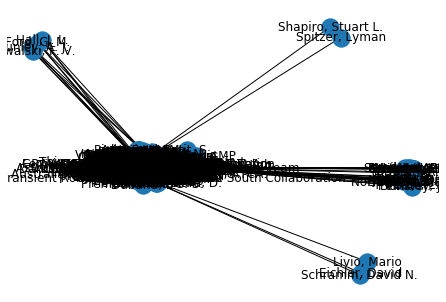

In [62]:
nx.draw(j_islands, with_labels=True)

In [34]:
#plt.figure(figsize=(14, 10))
#nx.draw(a_islands, with_labels=True, node_size=100, node_color="skyblue", node_shape="s", alpha=0.8, linewidths=40)

island = ipycytoscape.CytoscapeWidget()
island.graph.add_graph_from_networkx(a_islands)

island.set_style([{
                        'selector': 'node',
                        'css': {
                            'content': 'a_islands(authors)',
                            'text-valign': 'center',
                            'color': 'white',
                            'text-outline-width': 2,
                            'text-outline-color': 'green',
                            'background-color': 'green'
                        }
                        }])

island

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'a…

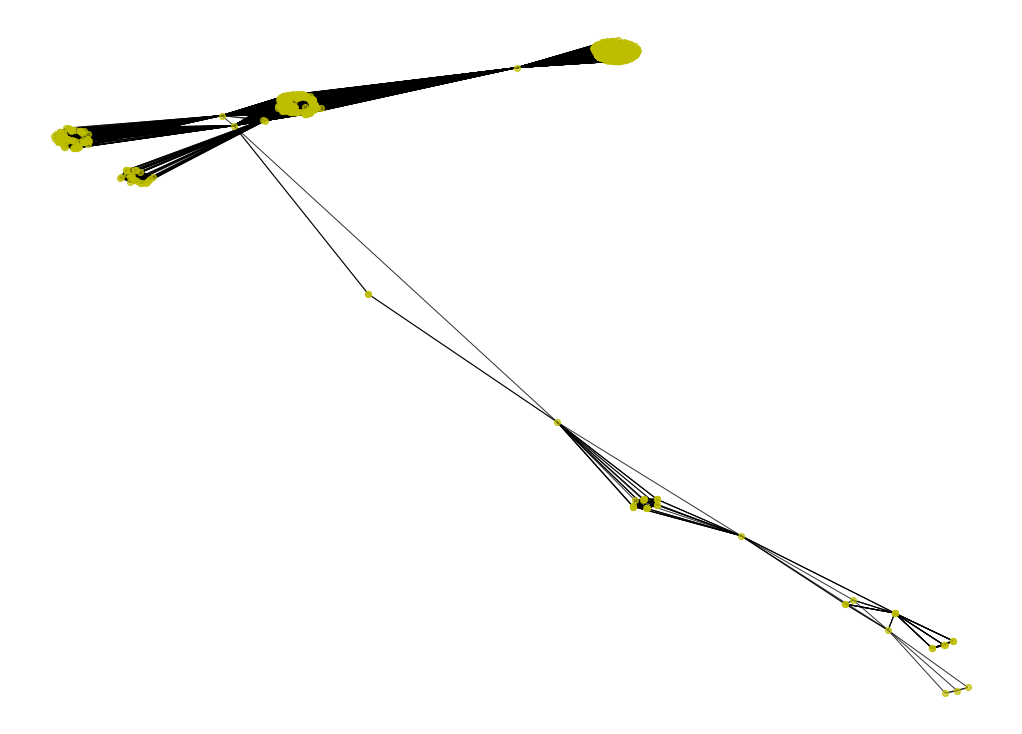

In [150]:
plt.figure(figsize=(14, 10))
nx.draw(j_islands, node_size=5, node_color="y", alpha=0.8, linewidths=5)
pos=nx.circular_layout(j_islands)